In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json
import urllib.parse
import urllib.request
import re
from tqdm import tqdm

### get pageview data from api

In [199]:
def get_pagestats(wiki, title, start, end):

    title = title.replace(" ", "_")
    title = urllib.parse.quote(title)
    # only consider human user
    url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/"\
        + wiki + "/all-access/user/"\
        + title + "/daily/" + start + "/" + end
    try:
        page = urllib.request.urlopen(url).read()
    except:
        # print("Error reading " + url)
        return
    page = page.decode("UTF-8")
    
    pageviews = {}
    items = json.loads(page)
    for item in items["items"]:
        views = int(item["views"])
        pageviews[item['timestamp']] = views
    
    # return pd.DataFrame(pageviews,index=pd.date_range(start=start, end=end), columns=[title])
    return pd.DataFrame(pageviews.values(), index=time_trans(pageviews.keys()), columns=[title])

In [200]:
def time_trans(date_list):
    """
    date follows pattern '2018010100'
    return datetime object
    """
    pattern = '(\d{4})(\d{2})(\d{2})(\d{2})'
    date_list = [re.sub(pattern, '\\1-\\2-\\3',date) for date in date_list]
    return [datetime.strptime(date, '%Y-%m-%d') for date in date_list]

In [201]:
def pageview_collection(page_list, start, end, wiki_country):
    """
    collect all pageview data across time
    return a dataframe
    """
    df_list = []
    for page in tqdm(set(page_list)):
        temp = get_pagestats(wiki_country,page, start, end)
        try:
            # only keep though high pageview data
            if np.mean(temp.iloc[:,0])>100:
                df_list.append(temp)
        except:
            continue
    
    # combine df for each page
    final = df_list[0]
    for m in df_list[1:]:
        final = final.join(m, how='outer')
    return final

In [202]:
covid_pageview = pageview_collection(covid_page, '20200101', '20200930', 'en.wikipedia')

100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [01:18<00:00,  7.95it/s]


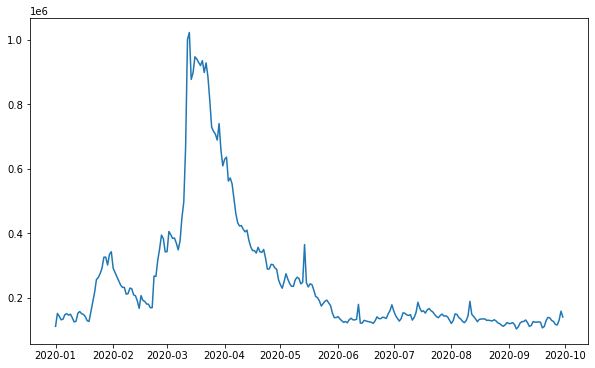

In [206]:
plt.figure(figsize=(10,6))
plt.plot(covid_pageview.sum(axis=1))
plt.show()

In [236]:
noncovid_pageview = pageview_collection(noncovid_page, '20200101', '20200930', 'en.wikipedia')

100%|██████████████████████████████████████████████████████████████████████████████| 1059/1059 [06:24<00:00,  2.76it/s]


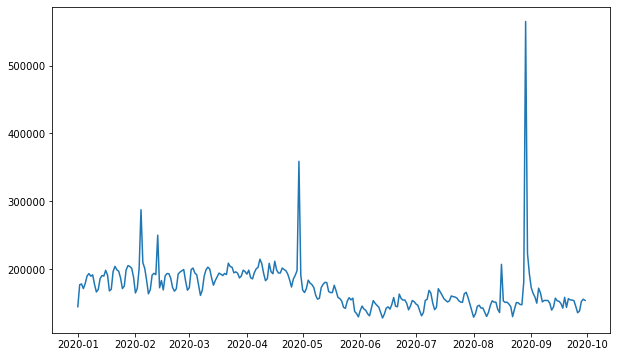

In [237]:
plt.figure(figsize=(10,6))
plt.plot(noncovid_pageview.sum(axis=1))
plt.show()

In [238]:
mental_pageview = pageview_collection(mental_page, '20200101', '20200930', 'en.wikipedia')

100%|████████████████████████████████████████████████████████████████████████████████| 927/927 [05:55<00:00,  2.61it/s]


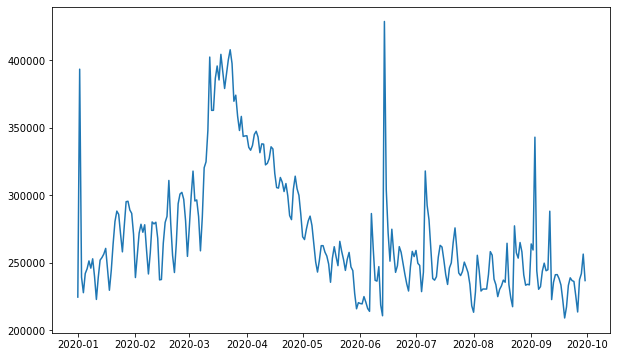

In [239]:
plt.figure(figsize=(10,6))
plt.plot(mental_pageview.sum(axis=1))
plt.show()

### get all page

In [30]:
from load import load_topics
topics_df, topics = load_topics('./data/topics_linked.csv.xz')
topics_df.head()

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
0,Rosmalen,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2001490
1,Commelinales,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q290349
2,Transport_in_Honduras,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q1130638
3,QuakeC,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2122062
4,Food_writing,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q5465542


In [207]:
keywords_df = pd.read_csv('./data/Key_words.csv')
keywords_df.head()

,covid symptoms,mental health,non-covid disease
0,fever,alcoholism,toothache
1,chills,panic disorder,stoke
2,cough,abuse,Cardiovascular diseases
3,shortness of breath,stress,indigestion
4,difficulty breathing,Bipolar disorder,constipation


In [226]:
def get_all_pages(all_pages, keywords):
    keywords = [word.replace(" ", "_").lower() for word in keywords]
    res=[]
    for keyword in keywords:
        for page in all_pages:
            if page.lower().find(keyword)!=-1:
                res.append(page)
    return res

In [231]:
# search on the medicine & health
all_pages = topics_df[topics_df['STEM.Medicine & Health']==True]
all_pages = [str(page) for page in all_pages['index'].to_list()]

covid_keywords = keywords_df['covid symptoms'].dropna().to_list()
covid_page = get_all_pages(all_pages, covid_keywords)

noncovid_keywords = keywords_df['non-covid disease'].dropna().to_list()
noncovid_page = get_all_pages(all_pages, noncovid_keywords)

mental_keywords = keywords_df['mental health'].dropna().to_list()
mental_page = get_all_pages(all_pages, mental_keywords)

In [235]:
len(covid_page)

624

In [233]:
len(noncovid_page)

1174

In [234]:
len(mental_page)

1023

In [107]:
# search on the medicine & health
df = topics_df[topics_df['STEM.Medicine & Health']==True]
topic_list = [str(page) for page in df['index'].to_list()]
res=[]
for keyword in covid_related:
    for page in topic_list:
        if page.lower().find(keyword)!=-1:
            res.append(page)
len(res) 

624

In [92]:
# search in the whole topic list
all_list = [str(page).lower() for page in topics_df['index'].to_list()]
res=[]
for keyword in covid_related:
    for page in all_list:
        if page.find(keyword)!=-1:
            res.append(page)
len(res) # 3408条